In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir("..")
from functools import reduce
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter
import statsmodels.api as sm
import ffn
from STRATEGY.BaseTradeEngine import BaseTradeEngine
sns.set(style='white')
import sys
import importlib
import warnings
from STRATEGY.BaseTradeEngine import BaseTradeEngine
from STRATEGY.Benchmark import Benchmark
from STRATEGY.Kalman import Kalman
importlib.reload(sys.modules['STRATEGY.BaseTradeEngine'])
from STRATEGY.BaseTradeEngine import BaseTradeEngine
importlib.reload(sys.modules['STRATEGY.Benchmark'])
from STRATEGY.Benchmark import Benchmark
importlib.reload(sys.modules['STRATEGY.Kalman'])
from STRATEGY.Kalman import Kalman
from UTIL import tradeUtil as tu


/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/ plots

In [2]:
a = pd.read_csv('STATICS/PRICE/rya.csv'  , index_col = 'date' )
b = pd.read_csv('STATICS/PRICE/ryaay.csv', index_col = 'date' )

402
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
|    |   sharpe_ratio |   long_ret |   short_ret |   spread_ret |   trans_ret |   n_transactions |   mean_hold_time |
|----+----------------+------------+-------------+--------------+-------------+------------------+------------------|
|  0 |          1.226 |      1.049 |       1.068 |        0.977 |       0.998 |               26 |            12232 |
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
Stats for cum rets from 2018-07-25 13:40:00 - 2019-11-01 14:50:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-                   1.23  7.72%   -3.51%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y    10y    incep.
-----  -----  -----  -----  -----  -----  ----  -----  --------
0.00%  

,sharpe_ratio,total_return,max_drawdown,long_ret,short_ret,spread_ret,trans_ret,n_transactions,mean_hold_time
0,1.226,NaN,-0.035,1.049,1.068,0.977,0.998,26,12232


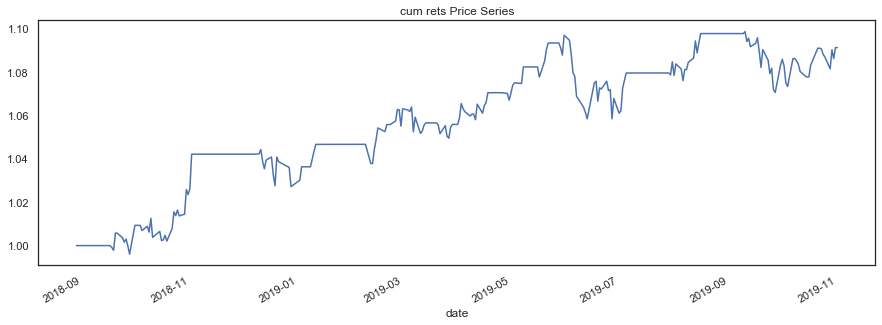

In [10]:
#x, y = BaseTradeEngine.clean_data(x, y, 'last', rm_outliers = True)

default = {'entryZ': 2, 'exitZ': -1, 'lag': 0, 'resample': 5, 'rounding': 3, 'windowZ': 120, 'windowOLS': 900, 'transaction_cost': 0.0063}
treatment = {'rm_outliers':True, 'rm_wide_spread': False, 'adjust_spread': False}

x, y = BaseTradeEngine.clean_data(a, b, 'last', **treatment)

ben = Benchmark(x, y, 'last','bid','ask', is_cleaned = True, **default)

ben.process(train_rng = [0,0.75],**default)
ben.get_summary(verbose=True)


+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
|    |   sharpe_ratio |   long_ret |   short_ret |   spread_ret |   trans_ret |   n_transactions |   mean_hold_time |
|----+----------------+------------+-------------+--------------+-------------+------------------+------------------|
|  0 |          1.543 |      1.101 |       1.102 |        0.937 |       0.993 |               82 |             5331 |
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
Stats for cum rets from 2018-07-25 13:40:00 - 2019-10-30 16:00:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
12.87%              1.54  10.04%  -4.71%

Annualized Returns:
mtd    3m     6m     ytd    1y      3y      5y    10y    incep.
-----  -----  -----  -----  ------  ------  ----  -----  --------
0.39%  

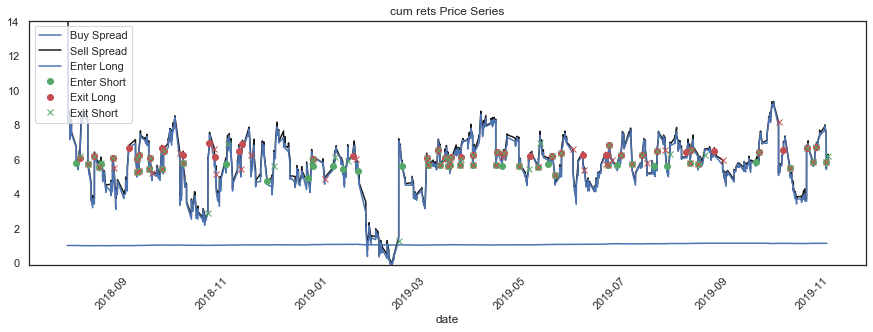

12.87 percent return in time window


In [12]:
#x, y = BaseTradeEngine.clean_data(x, y, 'last', rm_outliers = True)

default = {'lag': 0, 'resample': 20, 'rounding': 3, 'entryMult': 2.5, 'exitMult': -2.5, 'transaction_cost': 0.0063}
treatment = {'rm_outliers':True, 'rm_wide_spread': False, 'adjust_spread': False}

x, y = BaseTradeEngine.clean_data(a, b, 'last', **treatment)

ben = Kalman(x, y, 'last','bid','ask', is_cleaned = True, **default)
ben.process(train_rng = [0,0.75],**default)
ben.get_summary(verbose=True)
ben.plot_signals("2018-01-01","2020-01-25")


In [ ]:
from pykalman import KalmanFilter

delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x['last']], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
initial_state_mean=[0,0],
initial_state_covariance=np.ones((2, 2)),
transition_matrices=np.eye(2),
observation_matrices=obs_mat,
observation_covariance=2,
transition_covariance=trans_cov)
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y['last'].values)



In [ ]:
y.head()

In [104]:
n

date
2018-07-25 13:38:00    104.856089
2018-07-25 13:39:00    105.066423
2018-07-25 13:40:00    105.137406
Name: last, dtype: float64

In [108]:
pred = intercept + np.multiply(x['last'] ,slope)
error = y['last'] - pred
q = np.array([cov.std() for cov in state_covs])

In [109]:
longEnter = error < -q
print(sum(longEnter))
longExit = error > -q
print(sum(longExit))

shortEnter = error > q
print(sum(shortEnter))
shortExit = error < q
print(sum(shortExit))

96
26358
89
26365


In [6]:
slope=state_means[:, 0] 
intercept=state_means[:, 1]


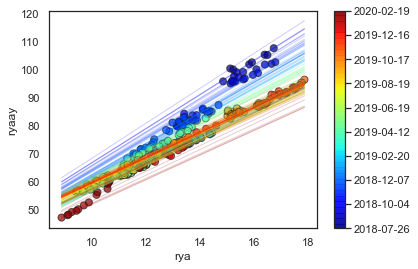

In [21]:
a = x.iloc[range(1,len(x),100)]
b = y.iloc[range(1,len(x),100)]

cm = plt.cm.get_cmap('jet')
dates = [str(p.date()) for p in a.iloc[range(1,len(a),int(len(a)/10))].index]
colors = np.linspace(0.1, 1, len(a))
sc = plt.scatter(a['last'], b['last'], s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in a.iloc[range(1,len(a),int(len(a)/10))].index])
plt.xlabel('rya')
plt.ylabel('ryaay')

# add regression lines
step = 200
xi = np.linspace(a['last'].min(), a['last'].max(), 20)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))


Text(0, 0.5, 'intercept')

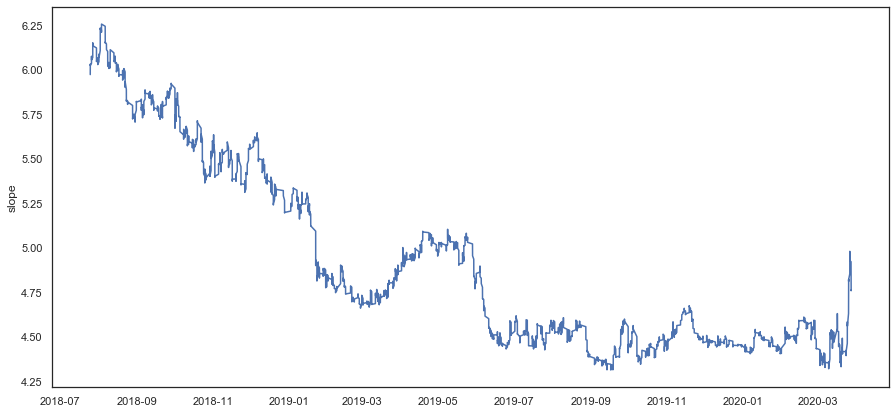

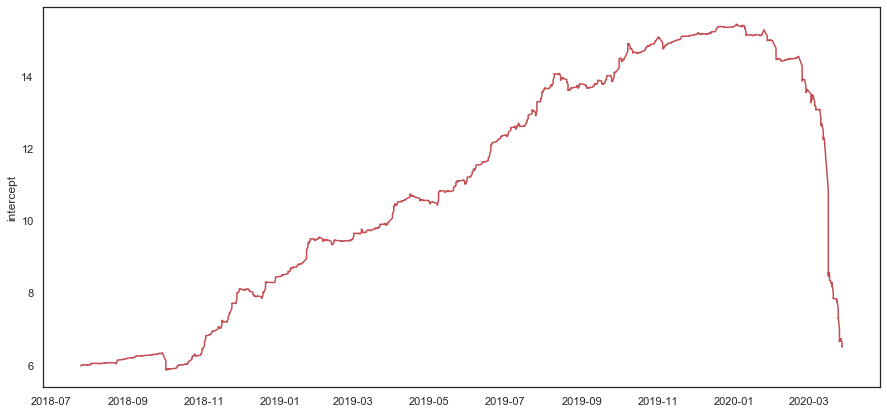

In [22]:
plt.figure(figsize =(15,7))
plt.plot(x.index, slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(x.index,intercept,c='r')
plt.ylabel('intercept')

In [ ]:




kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=measurements[0],
                  initial_state_covariance=1,
                  observation_covariance=5,
                  transition_covariance=9) 
state_means, state_covariances = kf.filter(measurements)
state_std = np.sqrt(state_covariances[:,0])
print state_std
print state_means   
print state_covariances
import matplotlib.pyplot as plt
plt.plot(measurements, '-r', label='measurment')
plt.plot(state_means, '-g', label='kalman-filter output')
plt.legend(loc='upper left')
plt.show()


In [14]:
def draw_date_coloured_scatterplot(x, y):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(x)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
       x, y, 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in x[::plen//9].index]
    )
    plt.xlabel('rya')
    plt.ylabel('ryaay')
    plt.show()

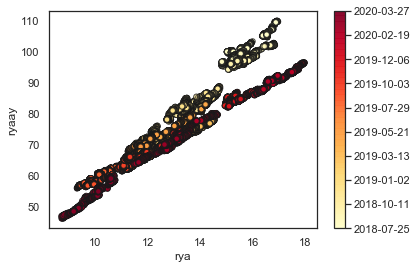

In [15]:
draw_date_coloured_scatterplot(x['last'],y['last'])

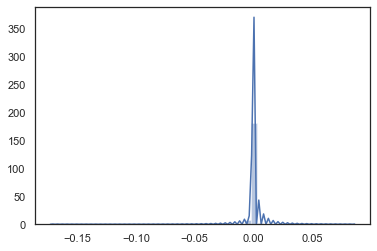

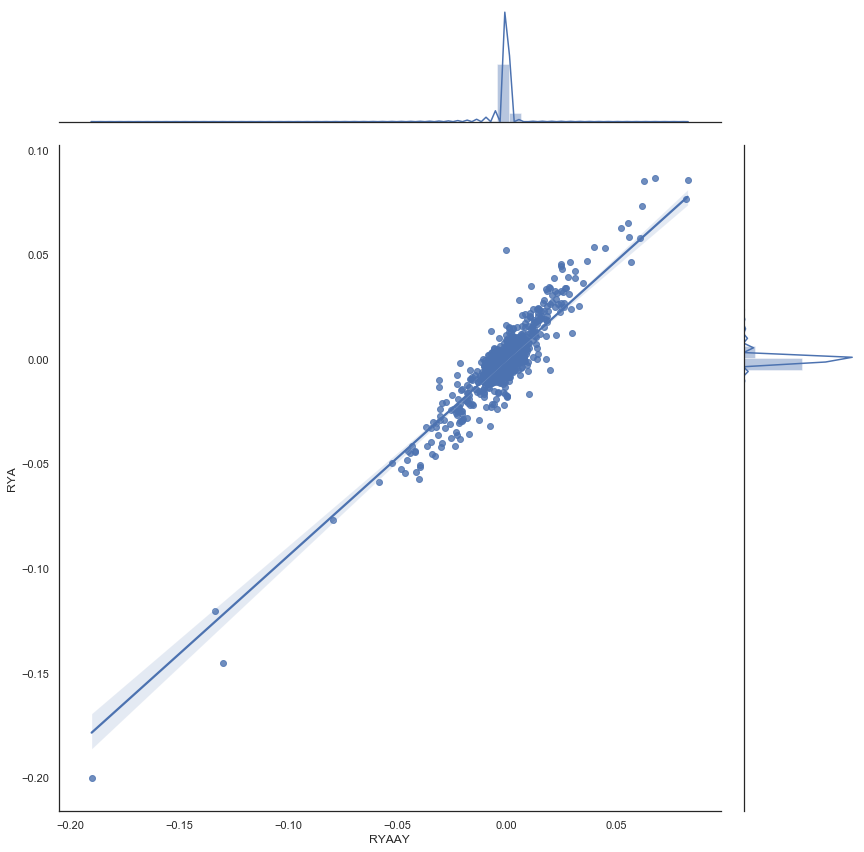

In [381]:
sns.distplot(returns.iloc[:,0:1])

log_ret_RYAAY = np.log(df['RYAAY']) - np.log(df['RYAAY'].shift(1)) 
log_ret_RYA = np.log(df['RYA']) - np.log(df['RYA'].shift(1))

#Plot using Seaborn's jointplot function
sns.jointplot(log_ret_RYAAY, log_ret_RYA, kind='reg', size=12)

In [31]:
import sys
import importlib
import warnings
from STRATEGY.BaseTradeEngine import BaseTradeEngine
from STRATEGY.Benchmark import Benchmark
from STRATEGY.Kalman import Kalman
importlib.reload(sys.modules['STRATEGY.BaseTradeEngine'])
from STRATEGY.BaseTradeEngine import BaseTradeEngine
importlib.reload(sys.modules['STRATEGY.Benchmark'])
from STRATEGY.Benchmark import Benchmark
importlib.reload(sys.modules['STRATEGY.Kalman'])
from STRATEGY.Kalman import Kalman
from UTIL import tradeUtil as tu

importlib.reload(sys.modules['UTIL.tradeUtil'])
from UTIL import tradeUtil as tu

In [8]:
plt.plot()

,last,bid,ask
date,,,
2018-07-25 08:37:00,16.824932,16.824932,16.824932
2018-07-25 08:39:00,16.827954,16.827954,16.833801
2018-07-25 08:40:00,16.826946,16.821100,16.826946
2018-07-25 08:41:00,16.827522,16.827522,16.827522
2018-07-25 08:43:00,16.826083,16.826083,16.826083
...,...,...,...
2020-03-27 15:51:00,10.125304,10.125304,10.138562
2020-03-27 15:52:00,10.114999,10.114999,10.132675
2020-03-27 15:53:00,10.128715,10.104409,10.128715


In [7]:
x = pd.read_csv('STATICS/PRICE/rya.csv'  , index_col = 'date' )
y = pd.read_csv('STATICS/PRICE/ryaay.csv', index_col = 'date' )

#x, y = BaseTradeEngine.clean_data(x, y, 'last', rm_outliers = True)

default = {'lag': 0, 'resample': 20.0, 'rounding': 3.0, 'entryMult': 3.0, 'exitMult': -2.0, 'transaction_cost': 0.0063,}

treatment = {'is_cleaned':False,'rm_outliers': False, 'rm_wide_spread': True, 'max_width': 10,
                                     'adjust_spread': True, 'adjust_width': 5}

kal = Kalman(x, y, 'last','bid','ask', **treatment, **default)
kal.process(train_rng = [0.05,1],**default)
kal.get_summary(verbose=True)
kal.plot_signals("2019-01-01","2019-01-25")

+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
|    |   sharpe_ratio |   long_ret |   short_ret |   spread_ret |   trans_ret |   n_transactions |   mean_hold_time |
|----+----------------+------------+-------------+--------------+-------------+------------------+------------------|
|  0 |          1.521 |      1.081 |       1.146 |         0.97 |       0.991 |              102 |             7641 |
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
Stats for cum rets from 2018-08-22 14:20:00 - 2020-03-27 15:20:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
19.11%              1.52  11.58%  -4.67%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y      5y    10y    incep.
-----  -----  -----  -----  -----  ------  ----  -----  --------
0.91%  2.

/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


ValueError: view limit minimum -36875.55 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36875.55 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1080x360 with 1 Axes>

In [25]:

output = []

------------------------------------------
rya vs ryaay pair trading using Kalman
------------------------------------------
Observations in source  | ryaay : 110795 , rya : 134001 
After merging on date   | ryaay : 27152 , rya : 27152 
After applying filters  | ryaay : 27152 , rya : 27152 


100%|██████████| 54/54 [00:06<00:00,  8.38it/s]


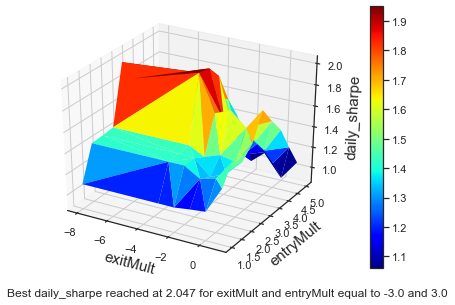

 63%|██████▎   | 34/54 [00:27<00:04,  4.59it/s]

KeyboardInterrupt: 

In [32]:
default = {'lag': 0, 'resample': 20, 'rounding': 3,  'entryMult':2, 'exitMult':-3, 'transaction_cost': 0.0063}

values  =  {'lag': 0, 'resample': [1,5,10,20,60,300], 'rounding': [2,3], 
            'entryMult': list(np.arange(1, 5.1, 0.5)), 'exitMult': [-8] + list(np.arange(1, -3.1, -1)),
           'rm_outliers': [True, False]}

treatment = {'is_cleaned':False,'rm_outliers': False, 'rm_wide_spread': True, 'max_width': 10,
                                     'adjust_spread': True, 'adjust_width': 5}

order   = np.array([['exitMult','entryMult'],['resample','entryMult'],['rm_outliers','rounding']])

output.extend(list(tu.backtest_model("rya", "ryaay", Kalman, default, values, order, version = "Kalman", **treatment)))


In [6]:
results = pd.concat(output, axis=1)
results.columns = pd.MultiIndex.from_tuples(results.columns, names=['Data','Sample','Model'])
display(results.transpose().sort_index(level = 'Data').style.background_gradient())

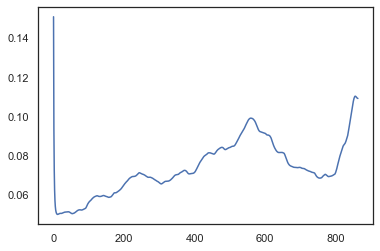

In [25]:
plt.plot(kal.std_q)

+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
|    |   sharpe_ratio |   long_ret |   short_ret |   spread_ret |   trans_ret |   n_transactions |   mean_hold_time |
|----+----------------+------------+-------------+--------------+-------------+------------------+------------------|
|  0 |          2.309 |      1.011 |       1.022 |        0.993 |       0.999 |               11 |             9681 |
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
Stats for cum rets from 2019-10-30 14:00:00 - 2020-02-04 15:00:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2.54%               2.31  9.90%   -1.38%

Annualized Returns:
mtd    3m     6m    ytd    1y    3y     5y    10y    incep.
-----  -----  ----  -----  ----  -----  ----  -----  --------
0.62%  2.75%  -

/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


,sharpe_ratio,total_return,max_drawdown,long_ret,short_ret,spread_ret,trans_ret,n_transactions,mean_hold_time
0,2.309,0.025,-0.014,1.011,1.022,0.993,0.999,11,9681


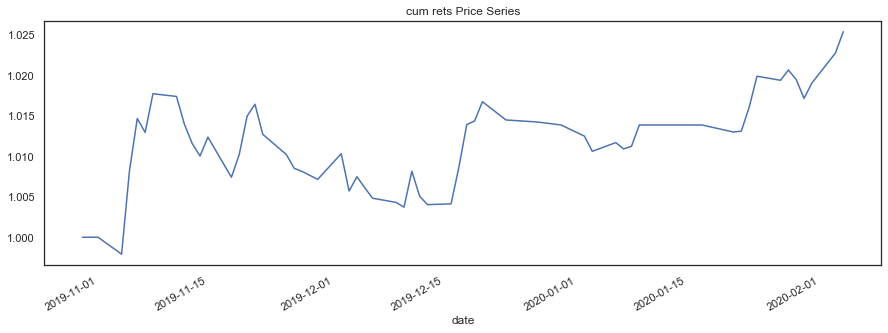

In [38]:
x = pd.read_csv('STATICS/PRICE/rya.csv'  , index_col = 'date' )
y = pd.read_csv('STATICS/PRICE/ryaay.csv', index_col = 'date' )

#x, y = BaseTradeEngine.clean_data(x, y, 'last', rm_outliers = True)

default = {'lag': 0, 'resample': 60.0, 'rounding': 3.0, 'entryMult': 5.0, 
           'exitMult': -2.0, 'transaction_cost': 0.0063, 'rm_outliers': 1.0}
kal = Kalman(x, y, 'last','bid','ask', **default)
kal.process(train_rng = [0.75,0.9],**default)
kal.get_summary(verbose=True)

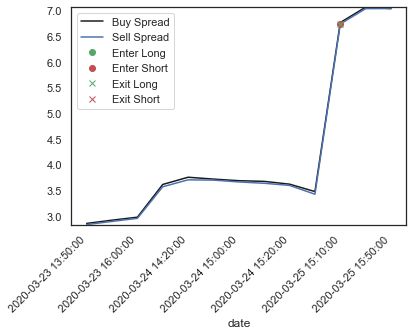

1.52 percent return in time window


In [34]:
kal.plot_signals("2020-03-23", "2020-03-25")

In [12]:
kal.record.to_csv("OUTPUT/TradeRecords/kalman_q.csv")

In [36]:
from STRATEGY.Copula import Copula

+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
|    |   sharpe_ratio |   long_ret |   short_ret |   spread_ret |   trans_ret |   n_transactions |   mean_hold_time |
|----+----------------+------------+-------------+--------------+-------------+------------------+------------------|
|  0 |         -4.352 |      1.018 |        1.01 |        0.932 |       0.977 |              213 |             1185 |
+----+----------------+------------+-------------+--------------+-------------+------------------+------------------+
Stats for cum rets from 2018-11-20 15:10:00 - 2020-01-17 15:25:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-6.41%             -4.35  -5.56%  -6.41%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y      5y    10y    incep.
------  ------  ------  ------  ------  ------  ----  -----  --------

,sharpe_ratio,total_return,max_drawdown,long_ret,short_ret,spread_ret,trans_ret,n_transactions,mean_hold_time
0,-4.352,-0.064,-0.064,1.018,1.01,0.932,0.977,213,1185


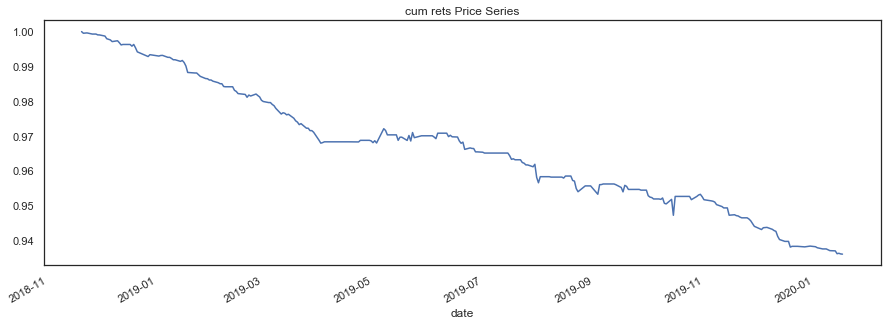

In [44]:




x = pd.read_csv('STATICS/PRICE/ul.csv'  , index_col = 'date' )
y = pd.read_csv('STATICS/PRICE/ulvr.csv', index_col = 'date' )

#x, y = BaseTradeEngine.clean_data(x, y, 'last', rm_outliers = True)

default = {'lag': 0, 'resample': 5.0, 'rounding': 3.0, 'windowOLS': 150,'copula_lookback': 200, 
           'recalibrate_n': 10, 'cap_CL': 0.98, 'floor_CL': 0.02, 'transaction_cost': 0.0063}

treatment = {'is_cleaned':False,'rm_outliers': False, 'rm_wide_spread': True, 'max_width': 10,
                                     'adjust_spread': True, 'adjust_width': 5}

cop = Copula(x, y, 'last','bid','ask', **treatment, **default)
cop.process(train_rng = [0.1,0.9],**default)
cop.get_summary(verbose=True)


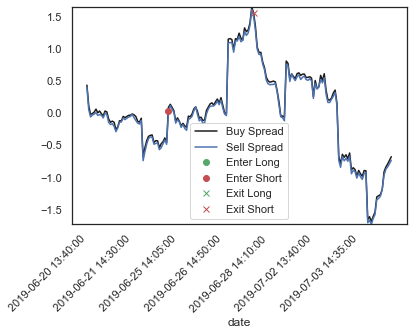

-1.23 percent return in time window


In [43]:
cop.plot_signals("2019-06-20", "2019-07-05")

In [20]:
import sys
import importlib
import warnings
from STRATEGY.BaseTradeEngine import BaseTradeEngine
from STRATEGY.Benchmark import Benchmark
from STRATEGY.Kalman import Kalman
importlib.reload(sys.modules['STRATEGY.BaseTradeEngine'])
from STRATEGY.BaseTradeEngine import BaseTradeEngine
importlib.reload(sys.modules['STRATEGY.Benchmark'])
from STRATEGY.Benchmark import Benchmark
importlib.reload(sys.modules['STRATEGY.Kalman'])
from STRATEGY.Kalman import Kalman
importlib.reload(sys.modules['STRATEGY.Copula'])
from STRATEGY.Copula import Copula
from UTIL import tradeUtil as tu

In [41]:
cop.record.to_csv("OUTPUT/TradeRecords/copulafirst.csv")

In [4]:
output = []

In [6]:


default = {'lag': 0, 'resample': 10, 'rounding': 3, 'windowOLS': 250, 
 'transaction_cost': 0.0063, 'copula_lookback': 150, 'recalibrate_n': 50, 'cap_CL': 0.95, 'floor_CL': 0.05,}

values  =  {'lag': [0,1,2], 'resample': [1,5,10,20,60,300], 'rounding': [2,3], 
            'copula_lookback': list(np.arange(100, 1000, 250)), 'recalibrate_n': [25,50,75],
           'windowZ': list(np.arange(25, 150, 30)), 'windowOLS': list(np.arange(150, 1200, 250))}

order   = np.array([['copula_lookback','resample'], ['resample','recalibrate_n'],
                    ['copula_lookback','windowOLS'],['resample','lag']])

output.extend(list(tu.backtest_model("rya", "ryaay", Copula, default, values, order, version = "Copula")))


------------------------------------------
rya vs ryaay pair trading using Copula
------------------------------------------
Observations in source  | ryaay : 110795 , rya : 134001 
After merging on date   | ryaay : 27152 , rya : 27152 
After removing outliers | ryaay : 26454 , rya : 26454 


KeyboardInterrupt: 

In [ ]:
#https://www.quantconnect.com/tutorials/strategy-library/pairs-trading-copula-vs-cointegration
#https://www.quantconnect.com/forum/discussion/2011/pairs-trading-copula-method-vs-cointegration/p1/comment-7975